In [1]:
import s3fs
import pyarrow.parquet as pq
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import duckdb

from datetime import datetime

In [4]:
plt.style.use('ggplot')
conn = duckdb.connect()

In [3]:
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "https://minio.minio-tenant",
        "aws_access_key_id": "admin",
        "aws_secret_access_key": "6bd71ace-8866-407a-9bcc-714bc5753f18",
        "verify": "/home/rafael/K8s/minio/minio-certs/cert-authority.pem",
    }
)

In [5]:
ghcn = pq.read_table("dutrajardim-fi/tables/ghcn.parquet", filesystem=fs)
shapes_relations = pq.read_table("dutrajardim-fi/tables/shapes/osm/relations.parquet/adm=8", filesystem=fs)

In [6]:
def x_fmt_func(labels):
    return ticker.FuncFormatter(lambda x, y: datetime.strptime(labels[x][:2], "%m").strftime("%b") + labels[x][2:])

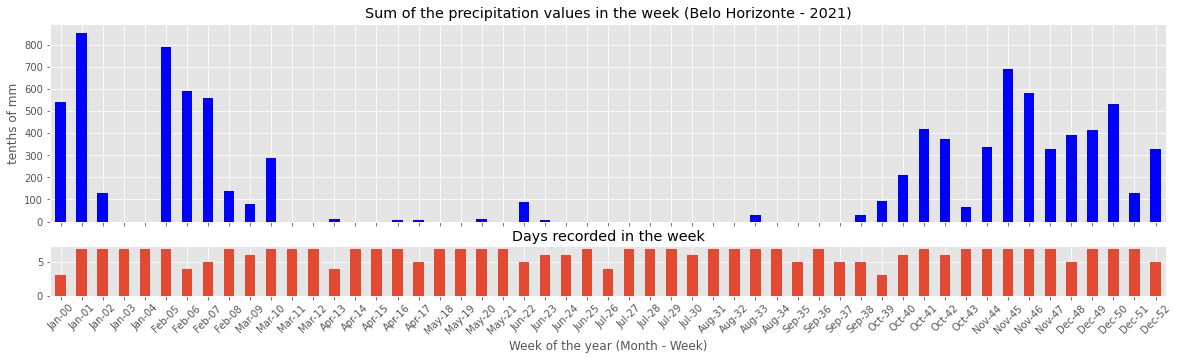

In [7]:
year = 2021
city = 'Belo Horizonte'

precipitation_by_week = conn.execute(f"""
SELECT weeks.week, COUNT(*) AS days_recorded, SUM(ghcn.value) as agg_value
FROM 

    (SELECT STRFTIME(generate_series, '%m-%W') as week
    FROM GENERATE_SERIES(TIMESTAMP '2021-01-01', TIMESTAMP '2021-12-31', INTERVAL 7 DAYS))
    
    weeks

LEFT JOIN
    
    (SELECT value, STRFTIME(datetime, '%m-%W') as week
    FROM ghcn
    JOIN shapes_relations ON ghcn.adm8 = shapes_relations.id
    WHERE
        distance_from_station = 0 AND
        shapes_relations.name = '{city}' AND
        ghcn.year = {year} AND
        element = 'PRCP')

    ghcn 

ON ghcn.week = weeks.week
GROUP BY weeks.week
ORDER BY weeks.week ASC
""").df()

fig, ax = plt.subplots(
    ncols=1, 
    nrows=2, 
    figsize=(20, 5), 
    sharex=True,
    gridspec_kw={'height_ratios': [4, 1]}
)

precipitation_by_week.plot(
    y='agg_value',
    ylabel='tenths of mm',
    ax=ax[0],
    kind='bar',
    color='blue',
    title=f"Sum of the precipitation values in the week ({city} - {year})",
    legend=False
)

precipitation_by_week.plot(
    y='days_recorded',
    xlabel='Week of the year (Month - Week)',
    ax=ax[1], 
    kind='bar', 
    legend=False,
    rot=45,
    title="Days recorded in the week"
)

ax[1].xaxis.set_major_formatter(x_fmt_func(precipitation_by_week['week']))

plt.show()

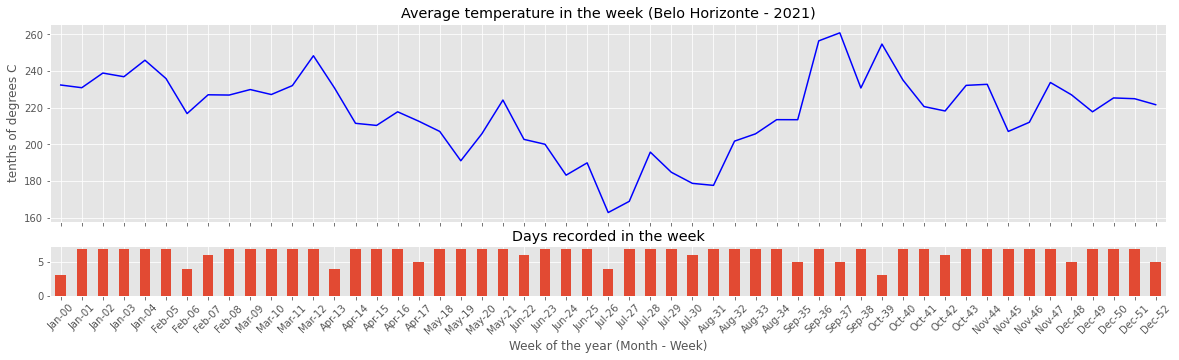

In [8]:
year = 2021
city = 'Belo Horizonte'

tavg_by_week = conn.execute(f"""
SELECT weeks.week, COUNT(*) AS days_recorded, AVG(ghcn.value) as agg_value
FROM 

    (SELECT STRFTIME(generate_series, '%m-%W') as week
    FROM GENERATE_SERIES(TIMESTAMP '2021-01-01', TIMESTAMP '2021-12-31', INTERVAL 7 DAYS))
    
    weeks

LEFT JOIN
    
    (SELECT value, STRFTIME(datetime, '%m-%W') as week
    FROM ghcn
    JOIN shapes_relations ON ghcn.adm8 = shapes_relations.id
    WHERE
        distance_from_station = 0 AND
        shapes_relations.name = '{city}' AND
        ghcn.year = {year} AND
        element = 'TAVG')

    ghcn 

ON ghcn.week = weeks.week
GROUP BY weeks.week
ORDER BY weeks.week ASC
""").df()

fig, ax = plt.subplots(
    ncols=1, 
    nrows=2, 
    figsize=(20, 5), 
    sharex=True,
    gridspec_kw={'height_ratios': [4, 1]}
)

tavg_by_week.plot(
    y='agg_value',
    ylabel='tenths of degrees C',
    ax=ax[0],
    color='blue',
    title=f"Average temperature in the week ({city} - {year})",
    legend=False
)

tavg_by_week.plot(
    y='days_recorded',
    xlabel='Week of the year (Month - Week)',
    ax=ax[1], 
    kind='bar', 
    legend=False,
    rot=45,
    title="Days recorded in the week"
)

ax[1].xaxis.set_major_formatter(x_fmt_func(tavg_by_week['week']))

plt.show()